<a href="https://colab.research.google.com/github/amaankazi81/Action-Recognition-using-MediaPipe-Landmarks-and-LSTM/blob/main/Action_Recognition_using_Landmarks_%2B_LSTM(45%2C225).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Liabraries**

In [1]:
# Install the required libraries.
!pip install pafy youtube-dl moviepy
!pip install mediapipe opencv-python rarfile
# Import the required libraries.
import os
import cv2
import mediapipe as mp
from tqdm import tqdm
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 27.9 MB/s eta 0:00:00


  if event.key is 'enter':



In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

**Downloading Dataset**

In [3]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

**Step 1: Visulaizing Dataset**

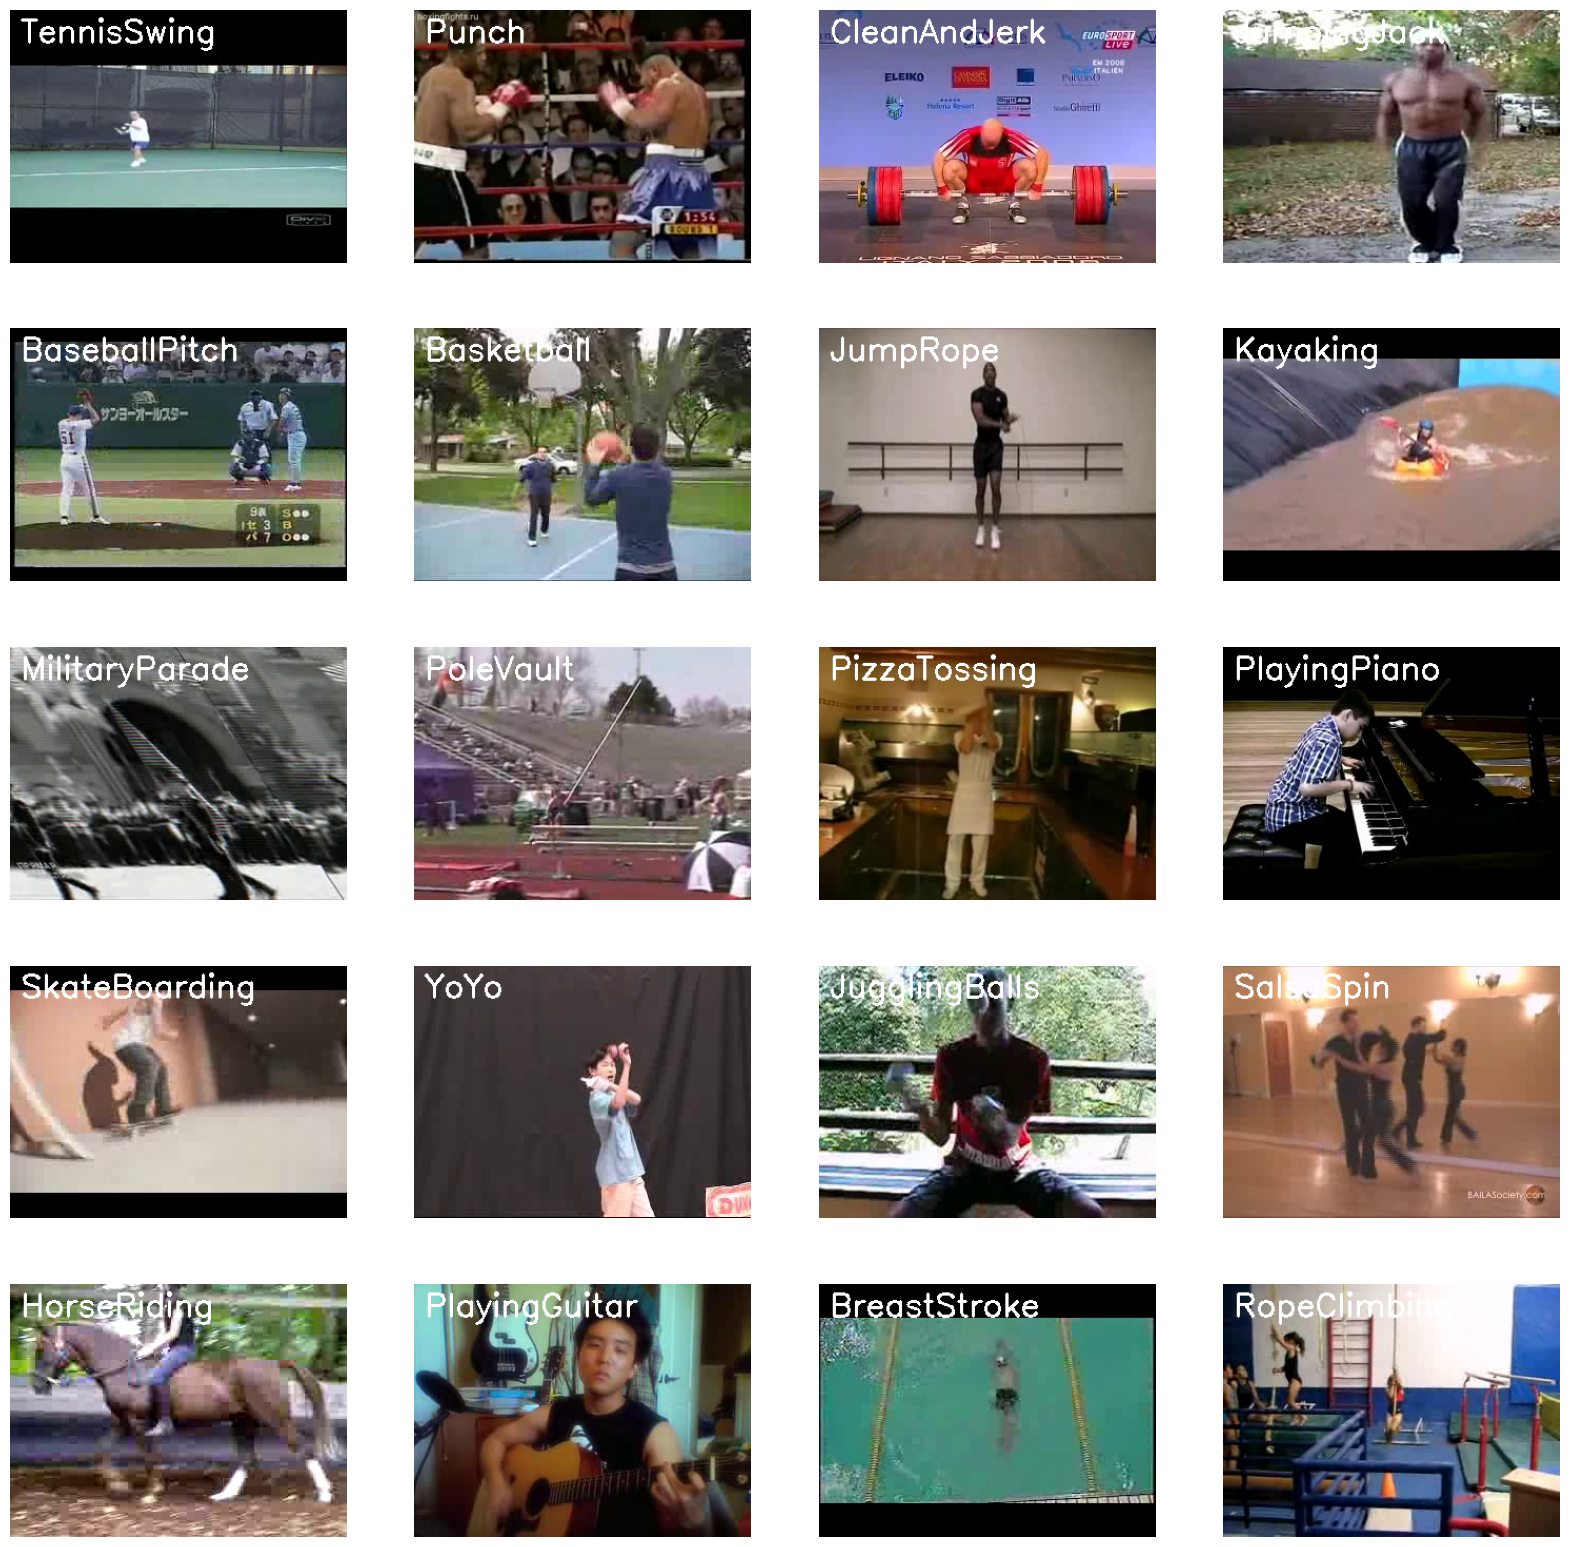

In [4]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

**Step 2: Preprocessing Dataset of Selected Actions**

In [5]:
import os

#Change this if your UCF50 path is different
UCF50_PATH = '/content/UCF50'  #Your dataset path
SAVE_PATH = 'UCF50_Landmarks'

selected_actions = ["TaiChi", "JumpingJack", "PushUps"]

#Create directories
for action in selected_actions:
    os.makedirs(os.path.join(SAVE_PATH, action), exist_ok=True)


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(selected_actions)
print(labels)

[2 0 1]


**Step 3: Taking Body Landmarks using MediaPipe**

In [7]:
import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm
import os

mp_holistic = mp.solutions.holistic

SEQUENCE_LENGTH = 45  #Number of frames per video
EXPECTED_SHAPE = 225

def extract_landmarks(results):
    def get_landmarks(landmarks, expected_count, include_visibility=False):
        if landmarks and hasattr(landmarks, 'landmark'):
            if include_visibility:
                return np.array([[l.x, l.y, l.z, l.visibility] for l in landmarks.landmark]).flatten()
            else:
                return np.array([[l.x, l.y, l.z] for l in landmarks.landmark]).flatten()
        else:
            return np.zeros(expected_count)

    #Sizes:Pose: 33 x 3 = 99, Hands: 21 x 3 x 2 = 126
    pose = get_landmarks(results.pose_landmarks, 33 * 3)
    lh = get_landmarks(results.left_hand_landmarks, 21 * 3)
    rh = get_landmarks(results.right_hand_landmarks, 21 * 3)

    return np.concatenate([pose, lh, rh])  # Total = 225

#Loop through selected actions
for action in selected_actions:
    action_dir = os.path.join(UCF50_PATH, action)
    save_dir = os.path.join(SAVE_PATH, action)

    if not os.path.exists(action_dir):
        print(f"❌ Folder not found for: {action}")
        continue

    video_files = [f for f in os.listdir(action_dir) if f.endswith('.avi')]

    for video_file in tqdm(video_files, desc=f"Processing {action}"):
        video_path = os.path.join(action_dir, video_file)
        cap = cv2.VideoCapture(video_path)

        sequence = []
        with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            frame_count = 0
            #Get total frames to potentially handle shorter videos gracefully later
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            while cap.isOpened() and len(sequence) < SEQUENCE_LENGTH:
                ret, frame = cap.read()
                if not ret:
                    break

                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                #Added error handling for Mediapipe process
                try:
                    results = holistic.process(image)
                except Exception as e:
                    continue

                keypoints = extract_landmarks(results)
                if keypoints.shape[0] == EXPECTED_SHAPE:
                    sequence.append(keypoints)

                #Check the shape of the extracted keypoints before appending
                EXPECTED_SHAPE = 225
                if keypoints.shape[0] == EXPECTED_SHAPE:
                    sequence.append(keypoints)
                else:
                    #If the shape is unexpected, print a warning and skip this frame
                    print(f"Warning: Unexpected keypoints shape {keypoints.shape} in frame {frame_count} of {video_file}. Expected {EXPECTED_SHAPE}. Skipping frame.")

                frame_count += 1

        cap.release()

        #Now we check if we collected exactly SEQUENCE_LENGTH frames with the correct shape
        if len(sequence) >= SEQUENCE_LENGTH:
            try:
                #Ensure the final numpy array has the correct and consistent shape
                final_sequence_array = np.array(sequence[:SEQUENCE_LENGTH])
                if final_sequence_array.shape == (SEQUENCE_LENGTH, EXPECTED_SHAPE):
                    npy_path = os.path.join(save_dir, video_file.replace('.avi', '.npy'))
                    np.save(npy_path, final_sequence_array)
                else:
                    print(f"Skipping {video_file} due to final sequence shape mismatch: {final_sequence_array.shape}")
            except ValueError as e:
                 print(f"Skipping {video_file} due to ValueError during np.array conversion: {e}")
        else:
            print(f"Skipping {video_file} due to insufficient frames with correct shape: {len(sequence)}/{SEQUENCE_LENGTH}")

Processing PushUps: 100%|██████████| 106/106 [03:32<00:00,  2.00s/it]


In [8]:
print(le.classes_)

['JumpingJack' 'PushUps' 'TaiChi']


**Step 4: Processing Slected Actions for LSTM Model**

In [41]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

DATA_PATH = "/content/UCF50_Landmarks"  #Your extracted body landmark dataset path

sequences = []
labels = []

for action_class in os.listdir(DATA_PATH):
    class_path = os.path.join(DATA_PATH, action_class)
    if not os.path.isdir(class_path):
        continue

    for file in os.listdir(class_path):
        if file.endswith(".npy"):
            data = np.load(os.path.join(class_path, file))
            if data.shape[0] == 45:
                sequences.append(data)
                labels.append(action_class)

#Convert to numpy arrays
X = np.array(sequences)
y = np.array(labels)

**Step 5: Split the Data into Train and Test Set**

In [42]:
#Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

**Step 6: Implement LSTM Model**

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.layers import Bidirectional

#Build the LSTM model
model = Sequential()

#1st LSTM Layer
model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(45, 225)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

#2nd LSTM Layer
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

#Fully Connected Layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(selected_actions), activation='softmax'))

#Compile
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

#Summary
model.summary()


  super().__init__(**kwargs)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 45, 128)             │         181,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 45, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,779 (921.01 KB)

 Trainable params: 235,395 (919.51 KB)

 Non-trainable params: 384 (1.50 KB)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=60, callbacks=callbacks, )


Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3823 - loss: 1.2106 

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.3917 - loss: 1.1986 - val_accuracy: 0.7358 - val_loss: 0.9579
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6038 - loss: 0.7760

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.6104 - loss: 0.7678 - val_accuracy: 0.7736 - val_loss: 0.8957
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7090 - loss: 0.6212

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.7126 - loss: 0.6173 - val_accuracy: 0.7358 - val_loss: 0.8486
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7913 - loss: 0.5455

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.7930 - loss: 0.5409 - val_accuracy: 0.7170 - val_loss: 0.8085
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8541 - loss: 0.4090

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.8539 - loss: 0.4068 - val_accuracy: 0.7358 - val_loss: 0.7676
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8223 - loss: 0.3946

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.8267 - loss: 0.3900 - val_accuracy: 0.7925 - val_loss: 0.7097
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8612 - loss: 0.3224 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8625 - loss: 0.3221 - val_accuracy: 0.8679 - val_loss: 0.6202
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9122 - loss: 0.2767

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.9113 - loss: 0.2756 - val_accuracy: 0.8868 - val_loss: 0.5555
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9144 - loss: 0.2489 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9162 - loss: 0.2480 - val_accuracy: 0.8491 - val_loss: 0.5126
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9313 - loss: 0.1974

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9322 - loss: 0.1978 - val_accuracy: 0.9057 - val_loss: 0.4042
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9218 - loss: 0.1952 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9238 - loss: 0.1930 - val_accuracy: 0.9057 - val_loss: 0.3708
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9286 - loss: 0.1977 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9280 - loss: 0.1979 - val_accuracy: 0.9057 - val_loss: 0.3304
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9565 - loss: 0.1599

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9542 - loss: 0.1609 - val_accuracy: 0.9623 - val_loss: 0.2510
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9468 - loss: 0.1610

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.9469 - loss: 0.1591 - val_accuracy: 0.9245 - val_loss: 0.2481
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9431 - loss: 0.1319

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.9448 - loss: 0.1304 - val_accuracy: 0.9811 - val_loss: 0.1911
Epoch 16/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9668 - loss: 0.1484 - val_accuracy: 0.9623 - val_loss: 0.2165
Epoch 17/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9657 - loss: 0.1010 - val_accuracy: 0.9623 - val_loss: 0.1961
Epoch 18/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9606 - loss: 0.0979 - val_accuracy: 0.9434 - val_loss: 0.2108
Epoch 19/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9428 - loss: 0.1434 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9440 - loss: 0.1413 - val_accuracy: 0.9623 - val_loss: 0.1676
Epoch 20/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9605 - loss: 0.1177 - val_accuracy: 0.9434 - val_loss: 0.1739
Epoch 21/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9720 - loss: 0.0774 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9726 - loss: 0.0767 - val_accuracy: 0.9434 - val_loss: 0.1615
Epoch 22/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9683 - loss: 0.0877 - val_accuracy: 0.9434 - val_loss: 0.2159
Epoch 23/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9762 - loss: 0.0671 - val_accuracy: 0.9623 - val_loss: 0.1638
Epoch 24/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.9830 - loss: 0.0687 - val_accuracy: 0.9245 - val_loss: 0.2041
Epoch 25/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9769 - loss: 0.0637 - val_accuracy: 0.9434 - val_loss: 0.2001
Epoch 26/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9800 - loss: 0.0617 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9807 - loss: 0.0607 - val_accuracy: 0.9434 - val_loss: 0.1435
Epoch 27/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9590 - loss: 0.0957 - val_accuracy: 0.9057 - val_loss: 0.2468
Epoch 28/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9807 - loss: 0.0595 - val_accuracy: 0.8868 - val_loss: 0.3059
Epoch 29/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9693 - loss: 0.0824 - val_accuracy: 0.8679 - val_loss: 0.4021
Epoch 30/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9510 - loss: 0.0904 - val_accuracy: 0.9623 - val_loss: 0.1571
Epoch 31/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9830 - loss: 0.0608 - val_accuracy: 0.9245 - val_loss: 0.1964
Epoch 32/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9668 - loss: 0.0675 - val_accuracy: 0.9434 - val_loss: 0.1834
Epoch 33/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9892 - loss: 0.0539 - val_accuracy: 0.9245 - val_loss: 0.2

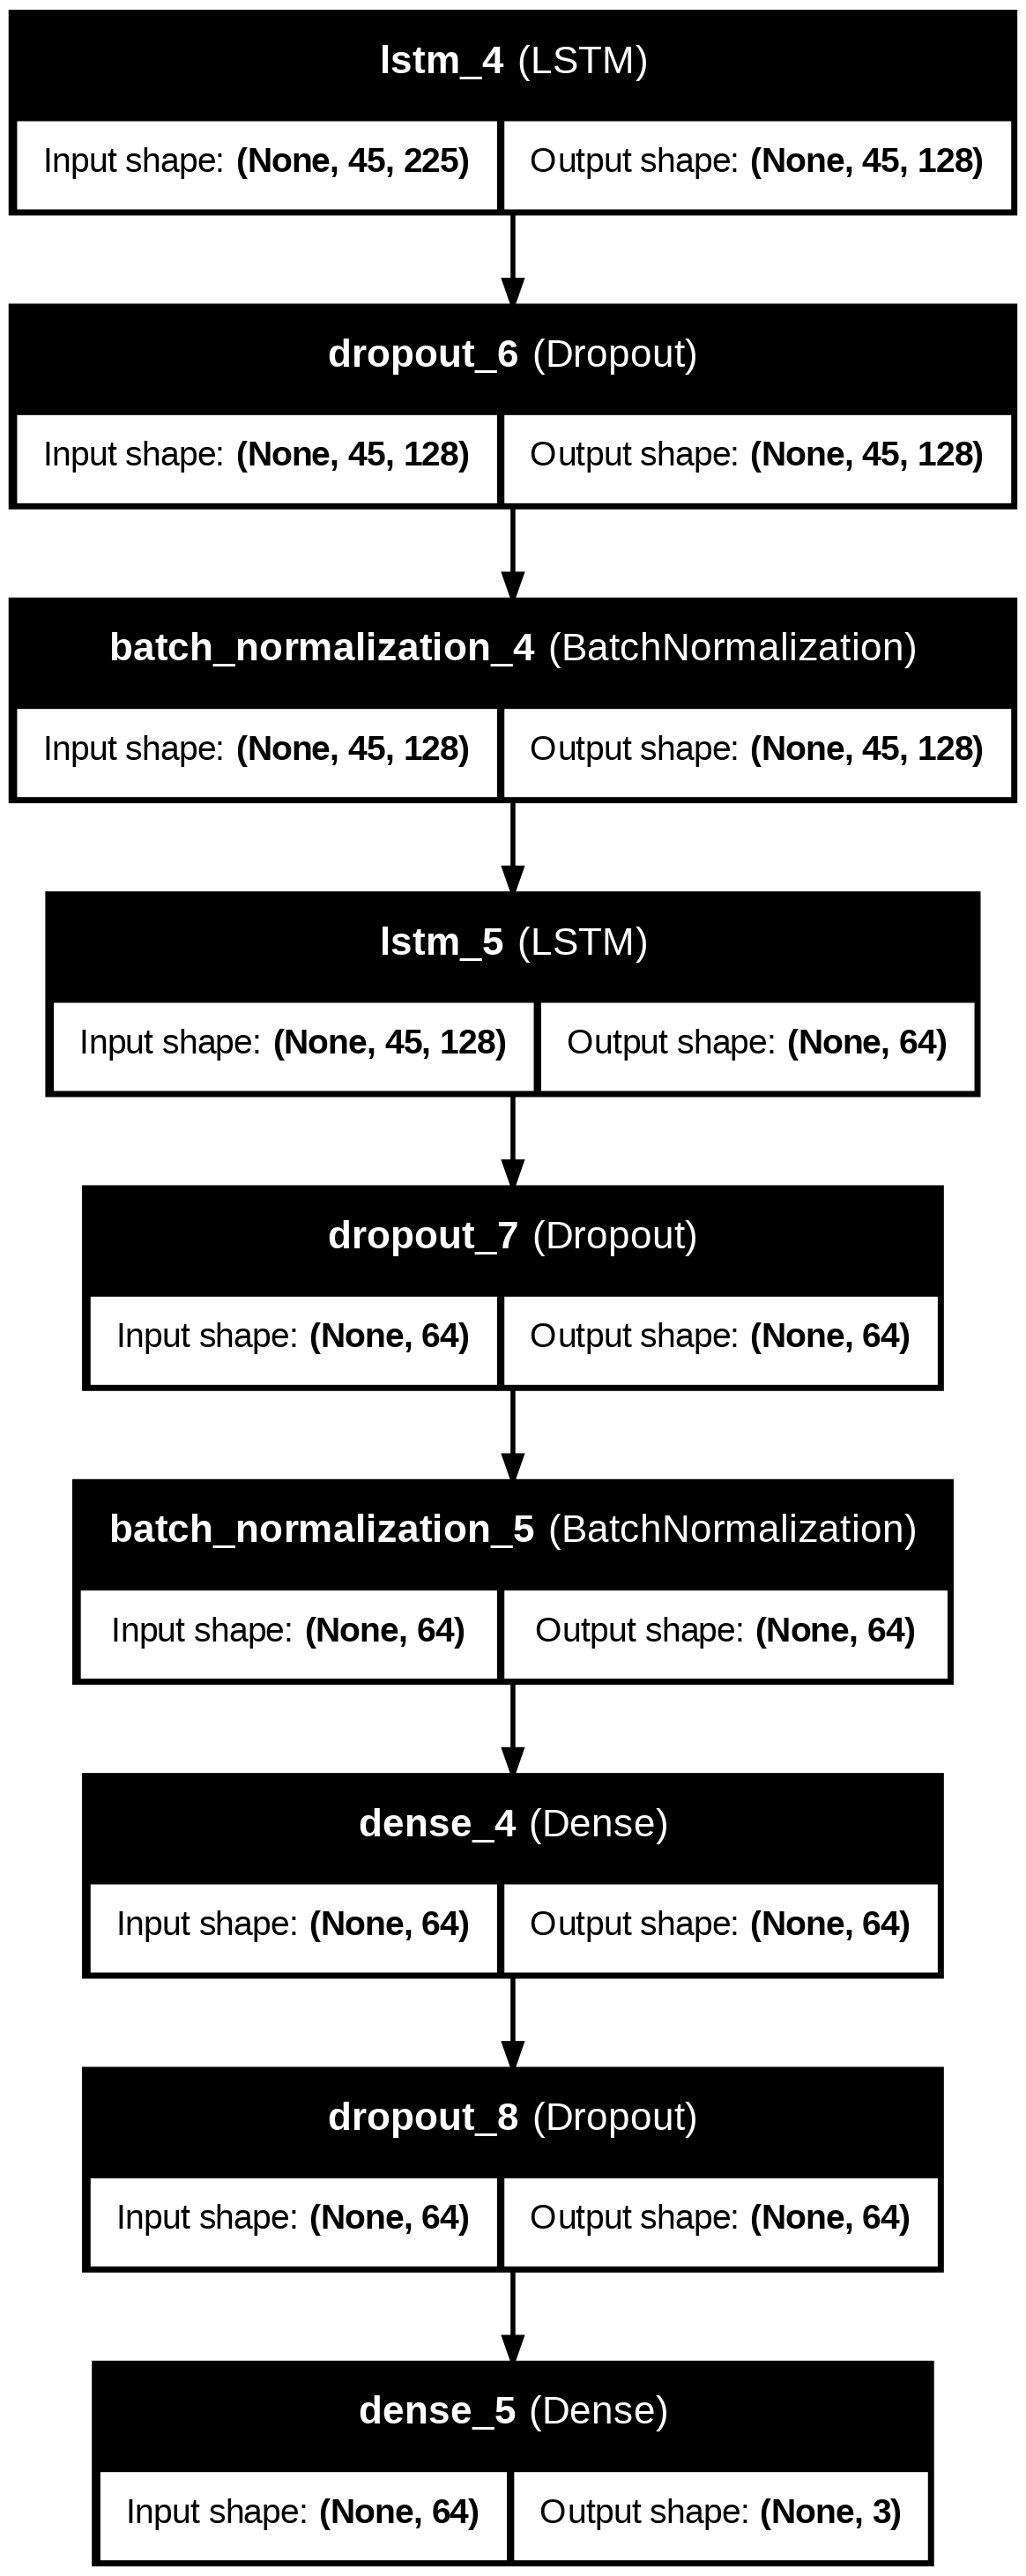

In [45]:
#Plot the structure of the contructed model.
plot_model(model, to_file = 'lstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Saving the Model

In [46]:
model.save('action_recognition_lstm.h5')

import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

Confusion Matrix

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


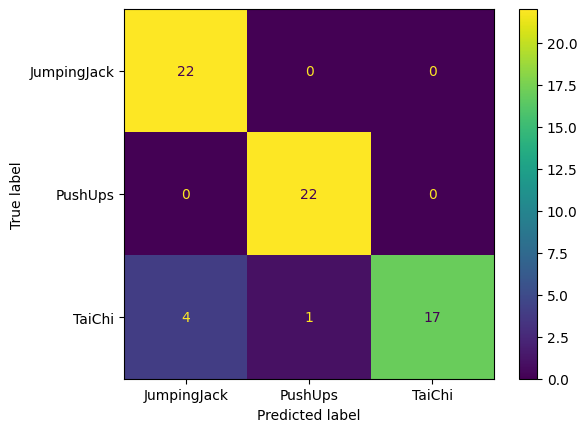

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=le.classes_)


**Step 7: Prediction on a Video**

In [48]:
import cv2
import numpy as np
import mediapipe as mp
import pickle
import os

model = tf.keras.models.load_model('action_recognition_lstm.h5')
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

mp_holistic = mp.solutions.holistic

SEQUENCE_LENGTH = 45
EXPECTED_SHAPE = 225

def extract_landmarks(results):
    def get_landmarks(landmarks, expected_count, include_visibility=False):
        if landmarks and hasattr(landmarks, 'landmark'):
            if include_visibility:
                return np.array([[l.x, l.y, l.z, l.visibility] for l in landmarks.landmark]).flatten()
            else:
                return np.array([[l.x, l.y, l.z] for l in landmarks.landmark]).flatten()
        else:
            return np.zeros(expected_count)

    pose = get_landmarks(results.pose_landmarks, 33 * 3, include_visibility=False)
    lh = get_landmarks(results.left_hand_landmarks, 21 * 3)
    rh = get_landmarks(results.right_hand_landmarks, 21 * 3)

    return np.concatenate([pose, lh, rh])

def process_video(video_path):
    sequence = []
    cap = cv2.VideoCapture(video_path)

    with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened() and len(sequence) < SEQUENCE_LENGTH:
            ret, frame = cap.read()
            if not ret:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)

            keypoints = extract_landmarks(results)
            if keypoints.shape[0] == EXPECTED_SHAPE:
                sequence.append(keypoints)

    cap.release()

    if len(sequence) == SEQUENCE_LENGTH:
        return np.array(sequence)
    else:
        raise ValueError(f"Only got {len(sequence)} valid frames. Need {SEQUENCE_LENGTH} for prediction.")


**Prediction**

In [49]:
sequence = process_video('/content/6326725-hd_1920_1080_25fps.mp4') #Video file path here
sequence = np.expand_dims(sequence, axis=0)

pred = model.predict(sequence)
class_id = np.argmax(pred)
predicted_action = le.inverse_transform([class_id])[0]

print(f"Predicted Action: {predicted_action}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Predicted Action: JumpingJack


**Finding Accuracy and Confusion Matrix**

In [50]:
import os
import numpy as np

X_test = []
y_test = []

TEST_PATH = '/content/UCF50_Landmarks'
selected_actions = ["TaiChi", "JumpingJack", "PushUps"]

for idx, action in enumerate(selected_actions):
    action_dir = os.path.join(TEST_PATH, action)
    if not os.path.isdir(action_dir):
        print(f"Warning: Directory not found for action: {action}")
        continue

    for file in os.listdir(action_dir):
        if file.endswith('.npy'):
            data_path = os.path.join(action_dir, file)
            try:
                data = np.load(data_path)
                if data.shape == (45, 225):
                    X_test.append(data)
                    y_test.append(action)
                else:
                    #Print files with unexpected shapes
                    print(f"Skipping file {file} in {action_dir} due to unexpected shape: {data.shape}")
            except Exception as e:
                print(f"Error loading file {file} in {action_dir}: {e}")


X_test = np.array(X_test)
y_test = np.array(y_test)
print(f"Test samples: {X_test.shape}, Labels: {y_test.shape}")

Test samples: (329, 45, 225), Labels: (329,)


In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)


In [52]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


✅ Accuracy: 94.83%


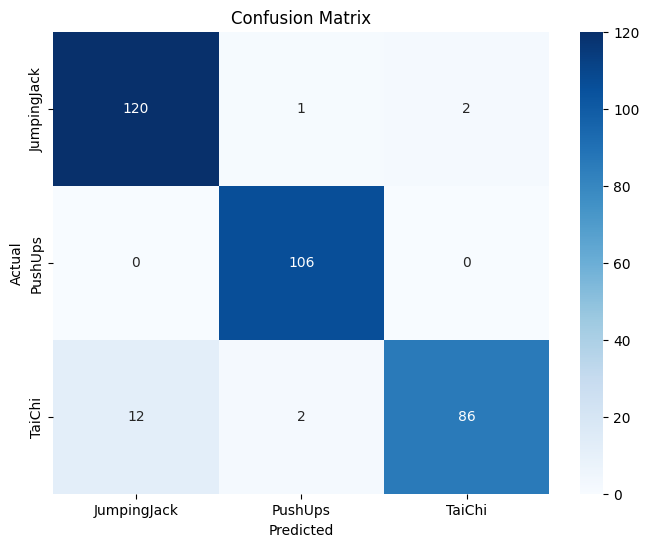

📊 Classification Report:
              precision    recall  f1-score   support

 JumpingJack       0.91      0.98      0.94       123
     PushUps       0.97      1.00      0.99       106
      TaiChi       0.98      0.86      0.91       100

    accuracy                           0.95       329
   macro avg       0.95      0.95      0.95       329
weighted avg       0.95      0.95      0.95       329



In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Accuracy of Model
acc = accuracy_score(y_test_encoded, y_pred)
print(f"✅ Accuracy: {acc * 100:.2f}%")

#Confusion Matrix Model
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Classification Report
print("📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))
